In [2]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
from sklearn.cluster import KMeans

In [4]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter=';')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Day_in_week"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,0,5
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5


In [5]:
# Clean
df_clean = df.drop_duplicates(subset=["Date", "id"], keep="last").copy()
df_clean.shape

(467061, 22)

# Fill in 0 for missing "Points (Total)"

In [6]:
df_points = df_clean[["Points (Total)", "Date", "id"]].copy()
# df_points = df_points[:100000].copy()

In [7]:
# Filtering out songs that appears less than 14 days
df_appear_count = df_clean.groupby('id').size().reset_index(name='count')
ids_to_be_used = df_appear_count[df_appear_count["count"] > 14]["id"]
df_points = df_points[df_points["id"].isin(ids_to_be_used)].copy()

In [8]:
all_dates = pd.date_range(start=df_points['Date'].min(), end=df_points['Date'].max(), freq='D')
uuids = df_points["id"].unique()

all_combinations = pd.MultiIndex.from_product([uuids, all_dates], names=['id', 'Date'])
full_df = pd.DataFrame(index=all_combinations).reset_index()

merged_df = pd.merge(full_df, df_points, on=['id', 'Date'], how='left')
merged_df['Points (Total)'].fillna(0, inplace=True)
merged_df

,id,Date,Points (Total)
0,3qQbCzHBycnDpGskqOWY0E,2017-01-01,0.0
1,3qQbCzHBycnDpGskqOWY0E,2017-01-02,0.0
2,3qQbCzHBycnDpGskqOWY0E,2017-01-03,0.0
3,3qQbCzHBycnDpGskqOWY0E,2017-01-04,0.0
4,3qQbCzHBycnDpGskqOWY0E,2017-01-05,0.0
...,...,...,...
8613535,36YCdzT57us0LhDmCYtrNE,2023-05-25,0.0
8613536,36YCdzT57us0LhDmCYtrNE,2023-05-26,0.0
8613537,36YCdzT57us0LhDmCYtrNE,2023-05-27,0.0
8613538,36YCdzT57us0LhDmCYtrNE,2023-05-28,0.0


<Axes: xlabel='Date', ylabel='Points (Total)'>

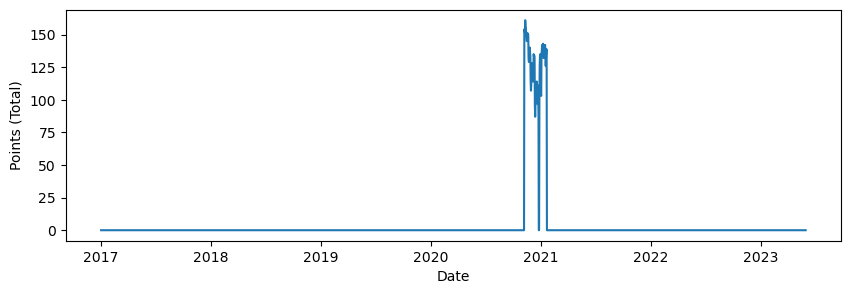

In [83]:
plt.figure(figsize=(10,3))
sample = merged_df.sample(n=1).iloc[0]
sns.lineplot(merged_df[merged_df["id"] == sample["id"]], x="Date", y="Points (Total)")

In [10]:
# Pivot the DataFrame for clustering
pivot_df = merged_df.pivot(index='id', columns='Date', values='Points (Total)')

In [11]:
pivot_df.to_csv("date_point_pop_only.csv")

In [40]:
pivot_df.head()

Date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2023-05-20,2023-05-21,2023-05-22,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df_diff = pivot_df.diff(axis=1)
df_diff.drop(columns="2017-01-01", inplace=True)
df_diff.head()

Date,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,...,2023-05-20,2023-05-21,2023-05-22,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


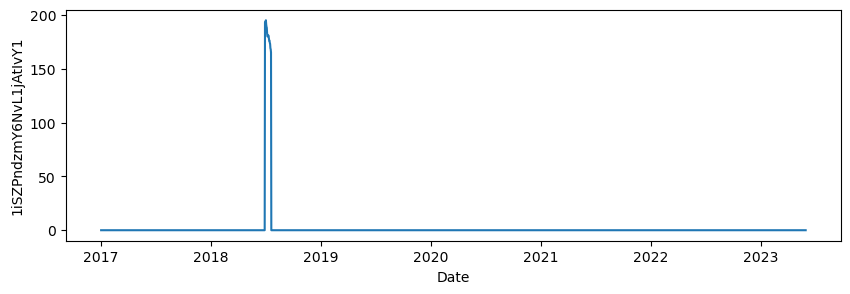

<Axes: xlabel='Date', ylabel='1iSZPndzmY6NvL1jAtIvY1'>

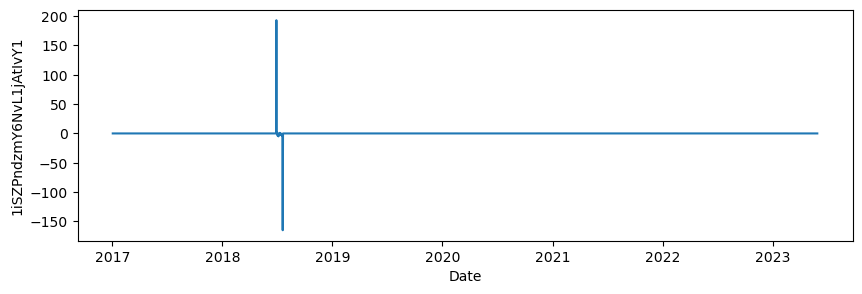

In [44]:
sample = pivot_df.sample(n=1)
sample_id = sample.index[0]

plt.figure(figsize=(10,3))
sns.lineplot(sample.iloc[0])

plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(df_diff.loc[sample_id])

# Song Popularity Over time

In [6]:
# all time hit, 6RUKPb4LETWmmr3iAEQktW, 5uCax9HTNlzGybIStD3vDh
# old release, but popular in 2022, 4xkOaSrkexMciUUogZKVTS, 4UKCKdYiLN6IMA5ZESUTL7, 1kKYjjfNYxE0YYgLa7vgVY
# popu. on and off, 2jyjhRf6DVbMPU5zxagN2h, 60a0Rd6pjrkxjPbaKzXjfq
# popu. on festival, 2TE4xW3ImvpltVU0cPcKUn, 15coTBAzEN1bOeipoNDZAR

id: 2TE4xW3ImvpltVU0cPcKUn | Total count: 93
Song: Merry Christmas Everyone | Artists: Shakin' Stevens | Continent: Europe


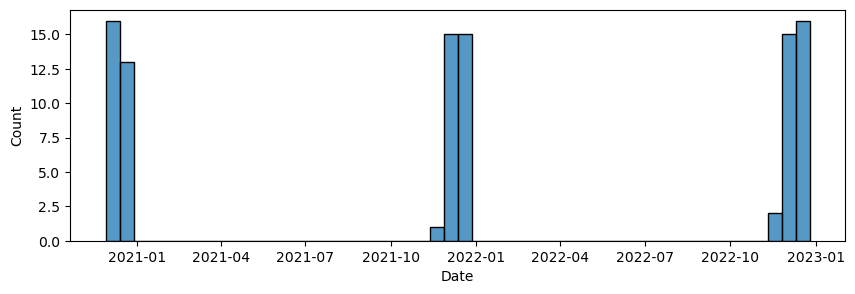

<Axes: xlabel='Date', ylabel='Points (Total)'>

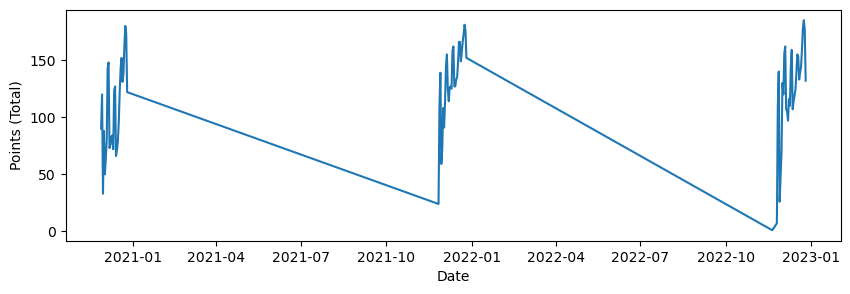

In [25]:
# sample = df_clean.sample(n=1).iloc[0]
sample = df_clean[df_clean["id"] == "2TE4xW3ImvpltVU0cPcKUn"].iloc[0]
df_focus = df_clean[df_clean["id"] == sample["id"]]

print(f'id: {sample["id"]} | Total count: {df_focus.shape[0]}')
print(f'Song: {sample["Title"]} | Artists: {sample["Artists"]} | Continent: {sample["Continent"]}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

# Artist Popularity Over time

Artists: Rich The Kid | Populary day count: 474 | Total song: 11


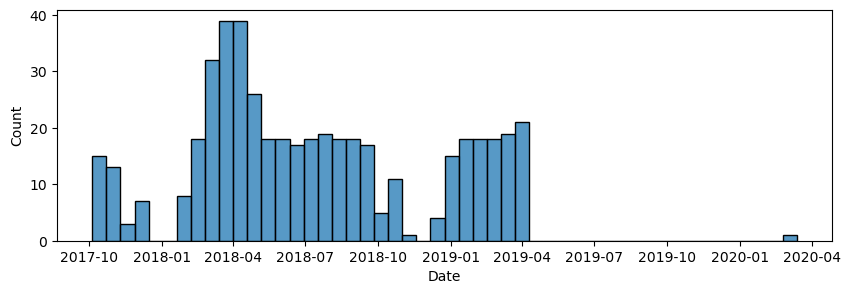

<Axes: xlabel='Date', ylabel='Points (Total)'>

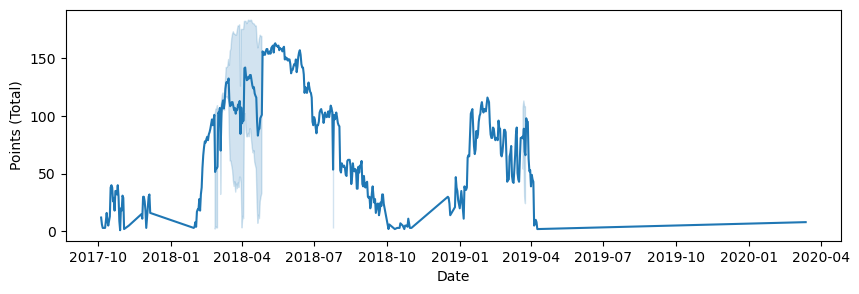

In [18]:
Artists = "Rich The Kid"

df_focus = df_clean[df_clean["Artists"] == Artists]
print(f'Artists: {Artists} | Populary day count: {df_focus.shape[0]} | Total song: {len(df_focus["Title"].unique())}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

# Name-included Popularity Over time

Word: summer | Populary day count: 1125 | Total song: 25


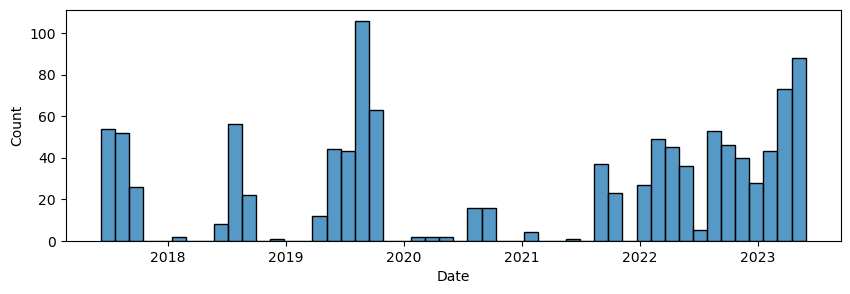

<Axes: xlabel='Date', ylabel='Points (Total)'>

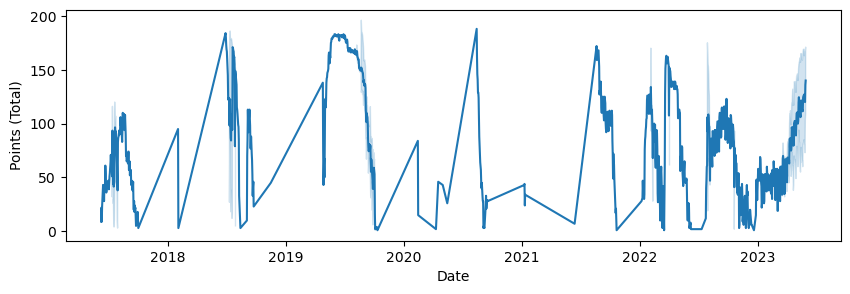

In [19]:
WordIncluded = "summer"

df_focus = df_clean[df_clean['Title'].str.contains("(?i)" + WordIncluded)]
print(f'Word: {WordIncluded} | Populary day count: {df_focus.shape[0]} | Total song: {len(df_focus["Title"].unique())}')

# Histogram
plt.figure(figsize=(10, 3))
sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

## Clustering (Draft)

<Axes: xlabel='cluster', ylabel='Count'>

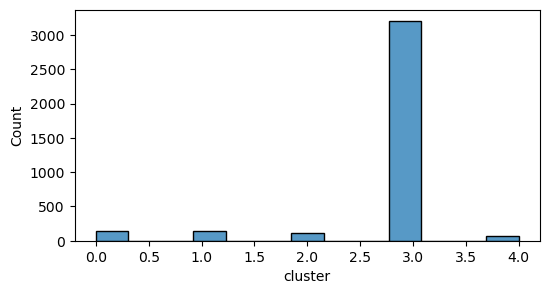

In [224]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = df_diff.copy()

kmeans = KMeans(n_clusters=5, n_init="auto")
kmeans.fit(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = kmeans.labels_
labels = kmeans.labels_

# pca = PCA(n_components=4)  # Reduce to 2 dimensions
# X_2d = pca.fit_transform(df_cluster_original)

# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

plt.figure(figsize=(6, 3))
sns.histplot(df_cluster["cluster"])

id: 3QIoEi8Enr9uHffwInGIsC


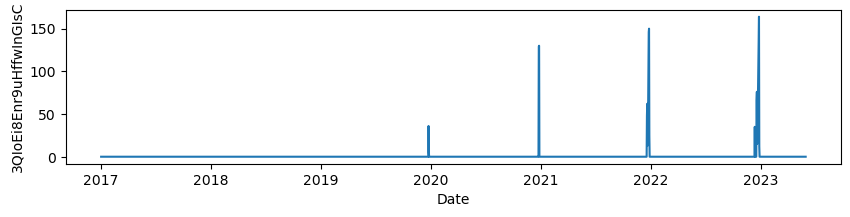

<Axes: xlabel='Date', ylabel='3QIoEi8Enr9uHffwInGIsC'>

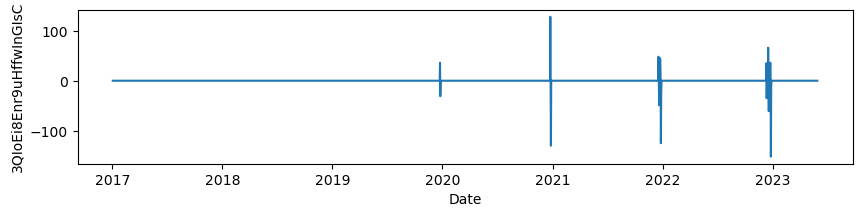

In [236]:
sample = df_cluster[df_cluster["cluster"] == 4].sample(n=1)
# sample = df_clean[df_clean["id"] == "2TE4xW3ImvpltVU0cPcKUn"].iloc[0]
sample_id = sample.index[0]
df_focus = pivot_df.loc[sample_id]

print(f'id: {sample_id}')
# print(f'Song: {sample["Title"]} | Artists: {sample["Artists"]} | Continent: {sample["Continent"]}')

# Histogram
# plt.figure(figsize=(10, 2))
# sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.figure(figsize=(10, 2))
sns.lineplot(df_focus)
plt.show()

# Differentiate Popularity over time
df_sample = sample.drop(columns="cluster")
plt.figure(figsize=(10, 2))
sns.lineplot(df_sample.iloc[0])